In [1]:
!pip install extinction
# remove if duplicate
import pandas as pd
import numpy as np
import os
import glob
from extinction import fitzpatrick99
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "mallorn-challenge/"
WAVELENGTHS = {'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056}
log_df = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
print(log_df.head(), log_df.shape)

                  object_id       Z  Z_err    EBV SpecType  \
0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   

                               English Translation     split  target  
0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
2                  Elves +  lover (fem.)  + breath  split_01       0  
3                    moon +  roof  +  noble maiden  split_01       0  
4            jewel, Silmaril  + father + Wild Man   split_01       0   (3043, 8)


Amount of duplicate object_id: 0

Amount of missing values (NA) in each column:
object_id                 0
Z                         0
Z_err                  3043
EBV                       0
SpecType                  0
English Translation       0
split                     0
target                    0
dtype: int64


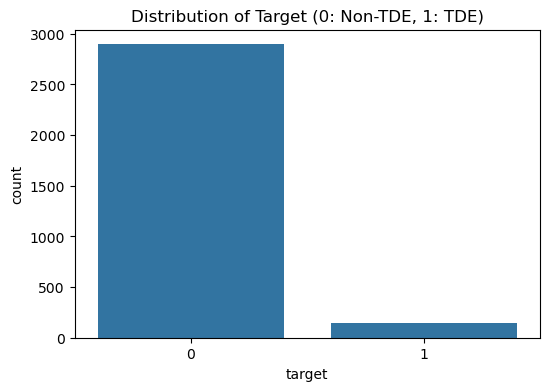

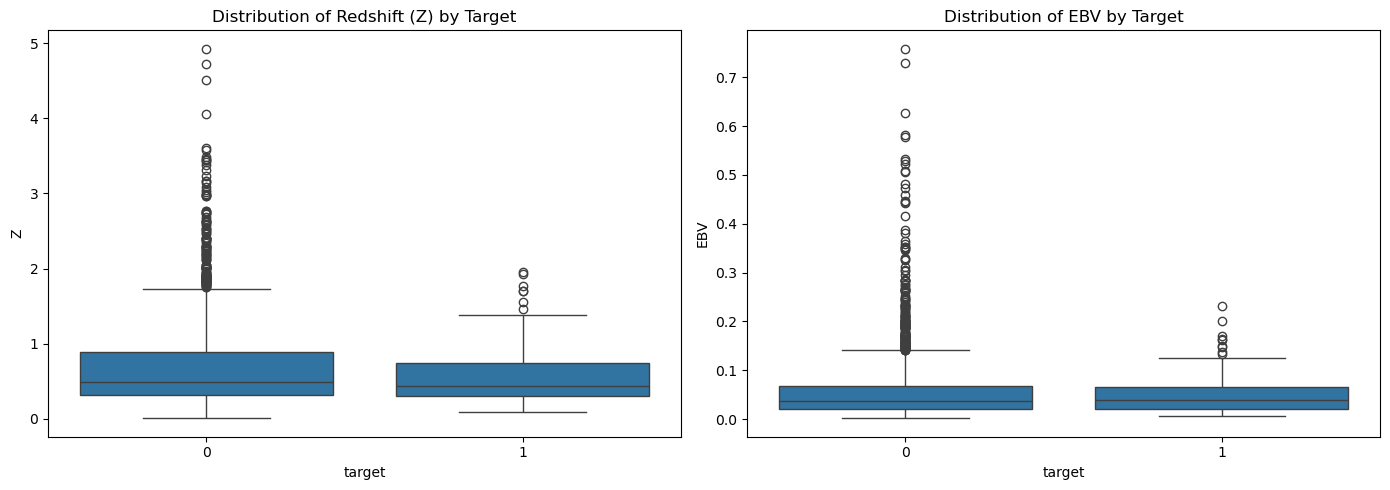

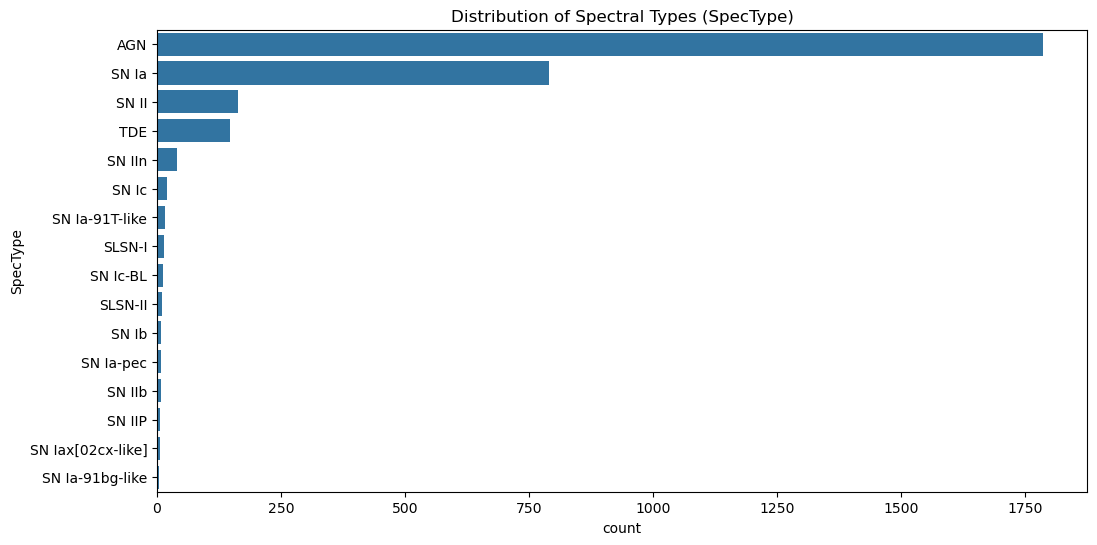

In [3]:
# 2.1. Check data quality (EDA Metadata)

# 1. Check duplicate object_id
n_duplicates = log_df['object_id'].duplicated().sum()
print(f"Amount of duplicate object_id: {n_duplicates}")

# 2. Count NA in each column
print("\nAmount of missing values (NA) in each column:")
print(log_df.isna().sum())

# 3. View target distribution (Class Imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(data=log_df, x='target')
plt.title("Distribution of Target (0: Non-TDE, 1: TDE)")
plt.show()

# 4. Histogram / Boxplot of Z, EBV by target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Redshift (Z)
sns.boxplot(data=log_df, x='target', y='Z', ax=axes[0])
axes[0].set_title("Distribution of Redshift (Z) by Target")

# EBV
sns.boxplot(data=log_df, x='target', y='EBV', ax=axes[1])
axes[1].set_title("Distribution of EBV by Target")

plt.tight_layout()
plt.show()

# 5. Distribution of SpecType (if available)
if 'SpecType' in log_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=log_df, y='SpecType', order=log_df['SpecType'].value_counts().index)
    plt.title("Distribution of Spectral Types (SpecType)")
    plt.show()
else:
    print("\nSpecType column not found in the data.")

**1. Some feedback personality here**
Non-TDE(target=0)≈2900
TDE(target=1)≈100-150
-> Imply this is imbalanced data problem--> consider use over sampling or under sampling techniques
-> if use model normally ML-> always predict non-TDE, high accuracy but useless model
-> apply 
- class weight in model training
- focal loss function
- oversampling techniques like SMOTE
- anomaly detection models

**2. RedShift**(Z) follow target"
Observed that Medians of botth class are similar
IQR(Interquartile Range) is quite stack together
non-TDE have many outliers(2-5), TDE have few outliers(0-1)
Conclusion:
Z is not strong feature to distinguish TDE and non-TDE
But Non-TDE have many objects in high redshift
TDE have redshift less than 1
-> secondary feature

**3. EBV dust extinction**
Median same 90%
Non-TDE have many outlier EBV (>=0.4-0.8)
EBV is not enough to distinct TDE


In [4]:
def process_flux(df):
    flux_ratio_sq = np.power(df['Flux'], 2) / np.power(df['Flux_err'], 2)
    df_flux = pd.DataFrame({'flux_ratio_sq': flux_ratio_sq, 
                            'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq},
                            index=df.index)
    return pd.concat([df, df_flux], axis=1)

In [5]:
def apply_de_extinction(df):
    wl_values = df['Filter'].map(WAVELENGTHS).values.astype(float)
    ebv_values = df['EBV'].values.astype(float)
    unit_extinction = fitzpatrick99(wl_values, 1.0)   
    a_lambda = unit_extinction * (ebv_values * 3.1)
    df['Flux_Real'] = df['Flux'] * (10 ** (a_lambda / 2.5))
    return df 

In [6]:
from semver import process

def process_data_pipeline(log_df, is_train=True):
    file_name = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"
    cols_to_use = ['object_id', 'EBV', 'Z']
    if is_train:
        cols_to_use.append('target')

    log_lookup = log_df[cols_to_use]
    all_features = []
    for i in range(1, 21):
        split_path = os.path.join(DATA_DIR, f"Split_{i:02d}", file_name)
        if os.path.exists(split_path):
            print(f"Processing {split_path}...")
            chunk_df = pd.read_csv(split_path)
            chunk_df = chunk_df.merge(log_lookup[['object_id', 'EBV', 'Z']], on='object_id', how='left')
            chunk_df = apply_de_extinction(chunk_df)
            chunk_df = process_flux(chunk_df)
            agg_dict = {
                'Flux_Real': ['max', 'mean', 'min', 'std'],
                'Time (MJD)': ['min', 'max'],
                'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
                'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
            }
            features = chunk_df.groupby(['object_id', 'Filter']).agg(agg_dict)
            features = features.unstack()
            features.columns = ['_'.join(map(str, col)).strip() for col in features.columns.values]
            features = features.reset_index()
            features = features.merge(log_lookup[['object_id', 'Z']], on='object_id', how='left')
            features['is_galactic'] = (features['Z'] < 0.005).astype(int)
            features['Log_Z'] = np.log1p(features['Z'])
            if 'Flux_Real_max_g' in features.columns and 'Flux_Real_max_r' in features.columns:
                features['color_g_r'] = features['Flux_Real_max_g'] - features['Flux_Real_max_r']
            else:
                features['color_g_r'] = 0
            if 'Flux_Real_max_u' in features.columns and 'Flux_Real_max_g' in features.columns:
                features['color_u_g'] = features['Flux_Real_max_u'] - features['Flux_Real_max_g']
            else:
                features['color_u_g'] = 0
            if 'Time_max_g' in features.columns and 'Time_min_g' in features.columns:
                duration_obs = features['Time_max_g'] - features['Time_min_g']
                features['duration_rest'] = duration_obs / (1 + features['Z'])
            else:
                features['duration_rest'] = 0
            all_features.append(features)
            del chunk_df
    if len(all_features) > 0:
        final_df = pd.concat(all_features, ignore_index=True)
        if is_train:
            final_df = final_df.merge(log_lookup[['object_id', 'target']], on='object_id', how='left')
        final_df = final_df.fillna(0)
        return final_df
    else:
        print("No data files found.")
        return None


In [7]:
# Step 1 Read file log
print(" Reading doc files log...")
train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
# Step 2 Call function process_data_pipeline to process data
print(" Processing training data...")
final_df = process_data_pipeline(train_log, is_train=True)
# Step 3 Check conclusions
if final_df is not None:
    print(" Final training data shape:", final_df.shape)
else:
    print(" Data processing failed.")


 Reading doc files log...
 Processing training data...
Processing mallorn-challenge/Split_01\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_02\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_03\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_04\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_05\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_06\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_07\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_08\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_09\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_10\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_11\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_12\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_13\train_full_lightcurves.csv...
Processing mallorn-challenge/Split_14\train_full_lightcurves.

In [8]:
# count amount of line of final_df with type tuple
type(final_df)

pandas.core.frame.DataFrame

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# 1. Prepare data
cols_to_drop = ['object_id', 'target']
X = final_df.drop(columns=cols_to_drop)
y = final_df['target']

# 2. Set up Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# FIX: Lưu xác suất (float) thay vì nhãn cứng (int) để tối ưu threshold sau này
oof_preds_proba = np.zeros(len(X)) 
models = [] 

print("🚀 Starting LightGBM training...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        scale_pos_weight=50, 
        random_state=42,
        verbose=-1
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    
    # FIX: Lấy xác suất của lớp 1 (TDE)
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    oof_preds_proba[val_idx] = val_preds_proba
    models.append(model)
    
    # Tạm tính F1 với ngưỡng mặc định 0.5 để in log chơi
    temp_preds = (val_preds_proba >= 0.5).astype(int)
    score = f1_score(y_val, temp_preds)
    print(f"Fold {fold+1}: F1-Score (Default 0.5) = {score:.4f}")

🚀 Starting LightGBM training...
Fold 1: F1-Score (Default 0.5) = 0.1176
Fold 2: F1-Score (Default 0.5) = 0.1667
Fold 3: F1-Score (Default 0.5) = 0.2162
Fold 4: F1-Score (Default 0.5) = 0.2162
Fold 5: F1-Score (Default 0.5) = 0.1714


In [10]:
# --- TÌM NGƯỠNG TỐI ƯU TRÊN TOÀN BỘ TẬP DỮ LIỆU (OOF) ---

# Tính Precision, Recall cho toàn bộ tập OOF
precision, recall, thresholds = precision_recall_curve(y, oof_preds_proba)
# Tính F1-Score cho từng ngưỡng
f1_scores = (2 * precision * recall) / (precision + recall)
# Tìm ngưỡng tốt nhất
best_idx = np.argmax(f1_scores[:-1]) 
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

# Apply this threshold to create the final predictions
final_oof_preds = (oof_preds_proba >= best_threshold).astype(int)

Best Threshold: 0.0015
Best F1-Score: 0.3667


In [11]:
overall_f1 = f1_score(y, final_oof_preds)
print(f"\nOverall F1-Score with Best Threshold: {overall_f1:.4f}")



Overall F1-Score with Best Threshold: 0.3667



🏆 OVERALL RESULTS (With Optimized Threshold):
              precision    recall  f1-score   support

     Non-TDE       0.97      0.95      0.96      2895
         TDE       0.31      0.45      0.37       148

    accuracy                           0.93      3043
   macro avg       0.64      0.70      0.66      3043
weighted avg       0.94      0.93      0.93      3043



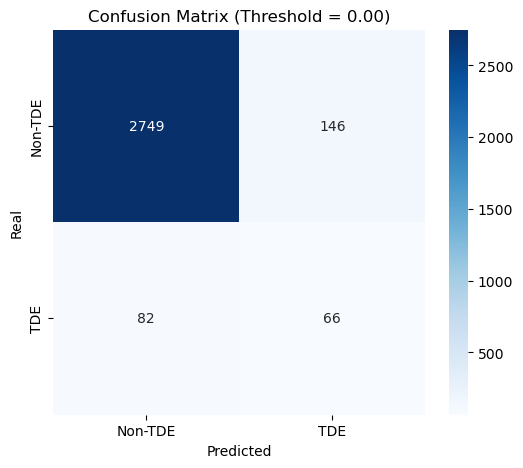

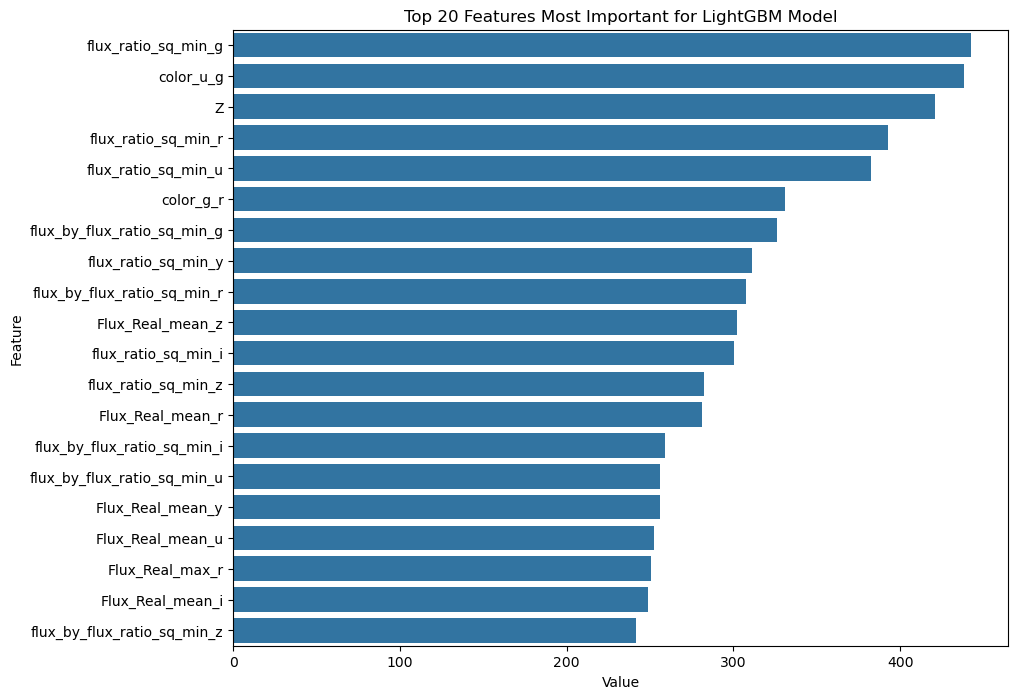

In [12]:
# --- RESULT ANALYSIS ---

# 1. Summary of scores
print("\n" + "="*50)
print("🏆 OVERALL RESULTS (With Optimized Threshold):")
print(classification_report(y, final_oof_preds, target_names=['Non-TDE', 'TDE']))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y, final_oof_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

# 3. Plot Feature Importance
feature_imp = pd.DataFrame({'Feature': X.columns, 'Value': 0})
for model in models:
    feature_imp['Value'] += model.feature_importances_
feature_imp['Value'] /= 5

plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('Top 20 Features Most Important for LightGBM Model')
plt.show()